##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Tensors and Operations

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/beta/tutorials/eager/basics"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/r2/tutorials/eager/basics.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/r2/tutorials/eager/basics.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/r2/tutorials/eager/basics.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This is an introductory TensorFlow tutorial shows how to:

* Import the required package
* Create and use tensors
* Use GPU acceleration
* Demonstrate `tf.data.Dataset`

In [0]:
from __future__ import absolute_import, division, print_function

!pip install tensorflow-gpu==2.0.0-beta1

## Import TensorFlow

To get started, import the `tensorflow` module. As of TensorFlow 2.0, eager execution is turned on by default. This enables a more interactive frontend to TensorFlow, the details of which we will discuss much later.

In [0]:
import tensorflow as tf

## Tensors

A Tensor is a multi-dimensional array. Similar to NumPy `ndarray` objects, `tf.Tensor` objects have a data type and a shape. Additionally, `tf.Tensor`s can reside in accelerator memory (like a GPU). TensorFlow offers a rich library of operations ([tf.add](https://www.tensorflow.org/api_docs/python/tf/add), [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/matmul), [tf.linalg.inv](https://www.tensorflow.org/api_docs/python/tf/linalg/inv) etc.) that consume and produce `tf.Tensor`s. These operations automatically convert native Python types, for example:


In [0]:
print(tf.add(1, 2))
print(tf.add([1, 2], [3, 4]))
print(tf.square(5))
print(tf.reduce_sum([1, 2, 3]))

# Operator overloading is also supported
print(tf.square(2) + tf.square(3))

Each `tf.Tensor` has a shape and a datatype:

In [0]:
x = tf.matmul([[1]], [[2, 3]])
print(x)
print(x.shape)
print(x.dtype)

The most obvious differences between NumPy arrays and `tf.Tensor`s are:

1. Tensors can be backed by accelerator memory (like GPU, TPU).
2. Tensors are immutable.

### NumPy Compatibility

Converting between a TensorFlow `tf.Tensor`s and a NumPy `ndarray` is easy:

* TensorFlow operations automatically convert NumPy ndarrays to Tensors.
* NumPy operations automatically convert Tensors to NumPy ndarrays.

Tensors are explicitly converted to NumPy ndarrays using their `.numpy()` method. These conversions are typically cheap since the array and `tf.Tensor` share the underlying memory representation, if possible. However, sharing the underlying representation isn't always possible since the `tf.Tensor` may be hosted in GPU memory while NumPy arrays are always backed by host memory, and the conversion involves a copy from GPU to host memory.

In [0]:
import numpy as np

ndarray = np.ones([3, 3])

print("TensorFlow operations convert numpy arrays to Tensors automatically")
tensor = tf.multiply(ndarray, 42)
print(tensor)


print("And NumPy operations convert Tensors to numpy arrays automatically")
print(np.add(tensor, 1))

print("The .numpy() method explicitly converts a Tensor to a numpy array")
print(tensor.numpy())

## GPU acceleration

Many TensorFlow operations are accelerated using the GPU for computation. Without any annotations, TensorFlow automatically decides whether to use the GPU or CPU for an operation—copying the tensor between CPU and GPU memory, if necessary. Tensors produced by an operation are typically backed by the memory of the device on which the operation executed, for example:

In [0]:
x = tf.random.uniform([3, 3])

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

### Device Names

The `Tensor.device` property provides a fully qualified string name of the device hosting the contents of the tensor. This name encodes many details, such as an identifier of the network address of the host on which this program is executing and the device within that host. This is required for distributed execution of a TensorFlow program. The string ends with `GPU:<N>` if the tensor is placed on the `N`-th GPU on the host.



### Explicit Device Placement

In TensorFlow, *placement* refers to how individual operations are assigned (placed on) a device for execution. As mentioned, when there is no explicit guidance provided, TensorFlow automatically decides which device to execute an operation and copies tensors to that device, if needed. However, TensorFlow operations can be explicitly placed on specific devices using the `tf.device` context manager, for example:

In [0]:
import time

def time_matmul(x):
  start = time.time()
  for loop in range(10):
    tf.matmul(x, x)

  result = time.time()-start

  print("10 loops: {:0.2f}ms".format(1000*result))

# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# Force execution on GPU #0 if available
if tf.test.is_gpu_available():
  print("On GPU:")
  with tf.device("GPU:0"): # Or GPU:1 for the 2nd GPU, GPU:2 for the 3rd etc.
    x = tf.random.uniform([1000, 1000])
    assert x.device.endswith("GPU:0")
    time_matmul(x)

## Datasets

This section uses the [`tf.data.Dataset` API](https://www.tensorflow.org/guide/datasets) to build a pipeline for feeding data to your model. The `tf.data.Dataset` API is used to build performant, complex input pipelines from simple, re-usable pieces that will feed your model's training or evaluation loops.

### Create a source `Dataset`

Create a *source* dataset using one of the factory functions like [`Dataset.from_tensors`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensors), [`Dataset.from_tensor_slices`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices), or using objects that read from files like [`TextLineDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TextLineDataset) or [`TFRecordDataset`](https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset). See the [TensorFlow Dataset guide](https://www.tensorflow.org/guide/datasets#reading_input_data) for more information.

In [0]:
ds_tensors = tf.data.Dataset.from_tensor_slices([1, 2, 3, 4, 5, 6])

# Create a CSV file
import tempfile
_, filename = tempfile.mkstemp()

with open(filename, 'w') as f:
  f.write("""Line 1
Line 2
Line 3
  """)

ds_file = tf.data.TextLineDataset(filename)

### Apply transformations

Use the transformations functions like [`map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map), [`batch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch), and [`shuffle`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) to apply transformations to dataset records.

In [0]:
ds_tensors = ds_tensors.map(tf.square).shuffle(2).batch(2)

ds_file = ds_file.batch(2)

### Iterate

`tf.data.Dataset` objects support iteration to loop over records:

In [0]:
print('Elements of ds_tensors:')
for x in ds_tensors:
  print(x)

print('\nElements in ds_file:')
for x in ds_file:
  print(x)

In [0]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


In [0]:
!unzip "drive/My Drive/face_expression.zip"

Archive:  drive/My Drive/face_expression.zip
   creating: face_expression/
   creating: face_expression/train/
   creating: face_expression/train/Sad/
  inflating: face_expression/train/Sad/Sad_12931.png  
 extracting: face_expression/train/Sad/Sad_20173.png  
 extracting: face_expression/train/Sad/Sad_6354.png  
 extracting: face_expression/train/Sad/Sad_21134.png  
 extracting: face_expression/train/Sad/Sad_28121.png  
 extracting: face_expression/train/Sad/Sad_20522.png  
  inflating: face_expression/train/Sad/Sad_7122.png  
  inflating: face_expression/train/Sad/Sad_17286.png  
 extracting: face_expression/train/Sad/Sad_22260.png  
  inflating: face_expression/train/Sad/Sad_19674.png  
  inflating: face_expression/train/Sad/Sad_15203.png  
 extracting: face_expression/train/Sad/Sad_4596.png  
  inflating: face_expression/train/Sad/Sad_8524.png  
 extracting: face_expression/train/Sad/Sad_11800.png  
  inflating: face_expression/train/Sad/Sad_735.png  
 extracting: face_expression/t

In [0]:

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

Is there a GPU available: 
True


In [0]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [0]:
pic_size = 48

In [0]:
base_path = "face_expression/"

In [0]:
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


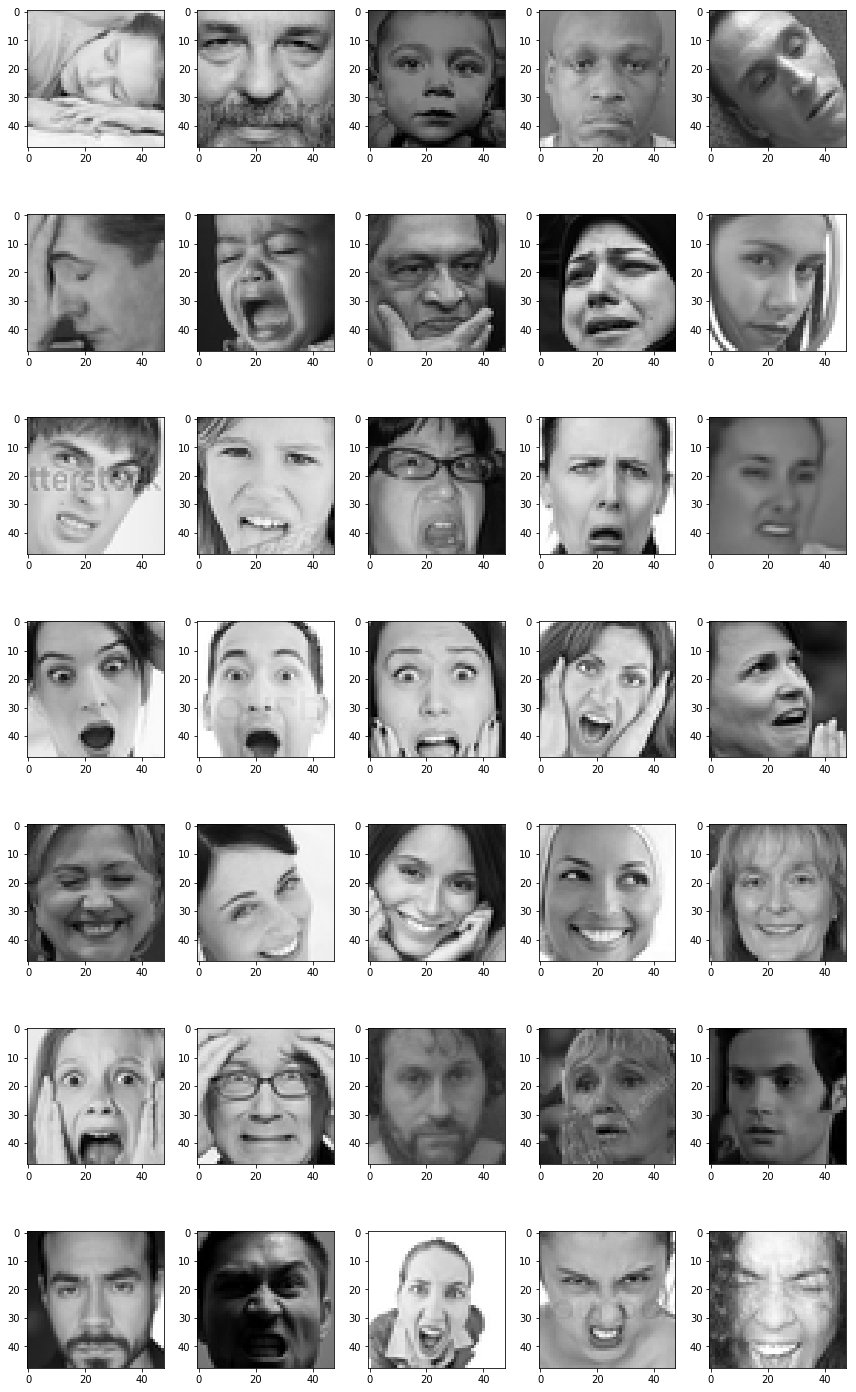

In [0]:
plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [0]:
for expression in os.listdir(base_path+"train"):
  print(str(len(os.listdir(base_path + "train/" + expression)))+ " "+ expression + " images")


4965 Neutral images
4830 Sad images
436 Disgust images
3171 Surprise images
7215 Happy images
4097 Fear images
3995 Angry images


In [0]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size = 128

In [0]:
datagen_train = ImageDataGenerator()
datagen_valid = ImageDataGenerator()

In [0]:
train_gen = datagen_train.flow_from_directory(base_path+"train", target_size=(pic_size,pic_size),
                                              color_mode="grayscale", batch_size=batch_size,
                                              class_mode= "categorical", shuffle = True)

valid_gen = datagen_train.flow_from_directory(base_path+"test", target_size=(pic_size,pic_size),
                                              color_mode="grayscale", batch_size=batch_size,
                                              class_mode= "categorical", shuffle = False)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [0]:
import tensorflow

In [0]:

print("Is there a GPU available: "),
print(tf.test.is_gpu_available())

Is there a GPU available: 
True


In [0]:
nb_classes = 7

In [0]:
model = tf.keras.models.Sequential([
      #1st conv layer
      tensorflow.keras.layers.Conv2D(64, (3,3), padding="same", input_shape=(48, 48, 1)),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.Activation('relu'),
      tensorflow.keras.layers.MaxPool2D(pool_size=(2,2)),
      tensorflow.keras.layers.Dropout(0.25),    

      #2nd conv layer
      tensorflow.keras.layers.Conv2D(128, (5,5), padding="same"),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.Activation('relu'),
      tensorflow.keras.layers.MaxPool2D(pool_size=(2,2)),
      tensorflow.keras.layers.Dropout(0.25),  

      #3rd conv layer
      tensorflow.keras.layers.Conv2D(512, (3,3), padding="same"),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.Activation('relu'),
      tensorflow.keras.layers.MaxPool2D(pool_size=(2,2)),
      tensorflow.keras.layers.Dropout(0.25),

      #4th conv layer
      tensorflow.keras.layers.Conv2D(512, (3,3), padding="same"),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.Activation('relu'),
      tensorflow.keras.layers.MaxPool2D(pool_size=(2,2)),
      tensorflow.keras.layers.Dropout(0.25),

      #flatten it
      tensorflow.keras.layers.Flatten(),

      #1st Dense layer
      tensorflow.keras.layers.Dense(256),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.Activation("relu"),
      tensorflow.keras.layers.Dropout(0.25),

      #2nd Dense layer
      tensorflow.keras.layers.Dense(512),
      tensorflow.keras.layers.BatchNormalization(),
      tensorflow.keras.layers.Activation("relu"),
      tensorflow.keras.layers.Dropout(0.25),

      #output layer

      tensorflow.keras.layers.Dense(nb_classes,activation="softmax")

                                 
])

In [0]:
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

In [0]:
model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
epoch = 40

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [0]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit_generator(generator=train_gen,
                              steps_per_epoch=train_gen.n//train_gen.batch_size,
                              epochs=epoch,
                              validation_data = valid_gen,
                              validation_steps = valid_gen.n//valid_gen.batch_size,
                              callbacks = callbacks_list)

Epoch 1/40
223/224 [============================>.] - ETA: 0s - loss: 1.9132 - accuracy: 0.2604

W0729 03:49:57.903915 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.9129 - accuracy: 0.2605 - val_loss: 1.7440 - val_accuracy: 0.2896
Epoch 2/40
223/224 [============================>.] - ETA: 0s - loss: 1.7777 - accuracy: 0.3179

W0729 03:50:17.348646 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 19s 87ms/step - loss: 1.7775 - accuracy: 0.3180 - val_loss: 1.6707 - val_accuracy: 0.3468
Epoch 3/40
223/224 [============================>.] - ETA: 0s - loss: 1.6901 - accuracy: 0.3526

W0729 03:50:36.896249 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 87ms/step - loss: 1.6902 - accuracy: 0.3524 - val_loss: 1.7378 - val_accuracy: 0.3510
Epoch 4/40
223/224 [============================>.] - ETA: 0s - loss: 1.6273 - accuracy: 0.3778

W0729 03:50:56.536759 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.6266 - accuracy: 0.3779 - val_loss: 1.6080 - val_accuracy: 0.3862
Epoch 5/40
223/224 [============================>.] - ETA: 0s - loss: 1.5711 - accuracy: 0.3965

W0729 03:51:16.104073 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 87ms/step - loss: 1.5707 - accuracy: 0.3966 - val_loss: 1.6574 - val_accuracy: 0.3744
Epoch 6/40
223/224 [============================>.] - ETA: 0s - loss: 1.5180 - accuracy: 0.4196

W0729 03:51:35.900105 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.5179 - accuracy: 0.4195 - val_loss: 1.6148 - val_accuracy: 0.3887
Epoch 7/40
223/224 [============================>.] - ETA: 0s - loss: 1.4772 - accuracy: 0.4357

W0729 03:51:55.854150 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 1.4774 - accuracy: 0.4355 - val_loss: 1.5223 - val_accuracy: 0.4149
Epoch 8/40
223/224 [============================>.] - ETA: 0s - loss: 1.4330 - accuracy: 0.4514

W0729 03:52:15.496868 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.4326 - accuracy: 0.4516 - val_loss: 1.5289 - val_accuracy: 0.4275
Epoch 9/40
223/224 [============================>.] - ETA: 0s - loss: 1.3924 - accuracy: 0.4677

W0729 03:52:35.373352 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 1.3919 - accuracy: 0.4679 - val_loss: 1.3914 - val_accuracy: 0.4634
Epoch 10/40
223/224 [============================>.] - ETA: 0s - loss: 1.3528 - accuracy: 0.4823

W0729 03:52:55.159387 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.3531 - accuracy: 0.4822 - val_loss: 1.3802 - val_accuracy: 0.4648
Epoch 11/40
223/224 [============================>.] - ETA: 0s - loss: 1.3237 - accuracy: 0.4898

W0729 03:53:14.963756 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.3244 - accuracy: 0.4897 - val_loss: 1.2914 - val_accuracy: 0.5000
Epoch 12/40
223/224 [============================>.] - ETA: 0s - loss: 1.2978 - accuracy: 0.5027

W0729 03:53:34.948674 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 1.2980 - accuracy: 0.5027 - val_loss: 1.3134 - val_accuracy: 0.4947
Epoch 13/40
223/224 [============================>.] - ETA: 0s - loss: 1.2683 - accuracy: 0.5147

W0729 03:53:54.676018 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.2679 - accuracy: 0.5148 - val_loss: 1.2343 - val_accuracy: 0.5212
Epoch 14/40
223/224 [============================>.] - ETA: 0s - loss: 1.2460 - accuracy: 0.5220

W0729 03:54:14.543031 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 1.2456 - accuracy: 0.5223 - val_loss: 1.2534 - val_accuracy: 0.5167
Epoch 15/40
223/224 [============================>.] - ETA: 0s - loss: 1.2105 - accuracy: 0.5400

W0729 03:54:34.510545 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 1.2110 - accuracy: 0.5398 - val_loss: 1.2198 - val_accuracy: 0.5279
Epoch 16/40
223/224 [============================>.] - ETA: 0s - loss: 1.2027 - accuracy: 0.5421

W0729 03:54:54.114232 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 87ms/step - loss: 1.2028 - accuracy: 0.5418 - val_loss: 1.2022 - val_accuracy: 0.5446
Epoch 17/40
223/224 [============================>.] - ETA: 0s - loss: 1.1777 - accuracy: 0.5521

W0729 03:55:13.983830 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 1.1778 - accuracy: 0.5522 - val_loss: 1.1792 - val_accuracy: 0.5419
Epoch 18/40
223/224 [============================>.] - ETA: 0s - loss: 1.1555 - accuracy: 0.5640

W0729 03:55:33.626882 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.1556 - accuracy: 0.5639 - val_loss: 1.1678 - val_accuracy: 0.5460
Epoch 19/40
223/224 [============================>.] - ETA: 0s - loss: 1.1380 - accuracy: 0.5683

W0729 03:55:53.450762 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.1380 - accuracy: 0.5683 - val_loss: 1.1638 - val_accuracy: 0.5485
Epoch 20/40
223/224 [============================>.] - ETA: 0s - loss: 1.1208 - accuracy: 0.5759

W0729 03:56:13.092475 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.1206 - accuracy: 0.5759 - val_loss: 1.1368 - val_accuracy: 0.5645
Epoch 21/40
223/224 [============================>.] - ETA: 0s - loss: 1.1026 - accuracy: 0.5810

W0729 03:56:32.680570 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 87ms/step - loss: 1.1031 - accuracy: 0.5806 - val_loss: 1.1420 - val_accuracy: 0.5720
Epoch 22/40
223/224 [============================>.] - ETA: 0s - loss: 1.0820 - accuracy: 0.5917

W0729 03:56:52.538757 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 1.0819 - accuracy: 0.5915 - val_loss: 1.1280 - val_accuracy: 0.5767
Epoch 23/40
223/224 [============================>.] - ETA: 0s - loss: 1.0573 - accuracy: 0.5972

W0729 03:57:12.272426 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.0576 - accuracy: 0.5973 - val_loss: 1.1349 - val_accuracy: 0.5703
Epoch 24/40
223/224 [============================>.] - ETA: 0s - loss: 1.0496 - accuracy: 0.6030

W0729 03:57:32.043808 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.0489 - accuracy: 0.6033 - val_loss: 1.1383 - val_accuracy: 0.5765
Epoch 25/40
223/224 [============================>.] - ETA: 0s - loss: 1.0334 - accuracy: 0.6133

W0729 03:57:51.597137 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 87ms/step - loss: 1.0331 - accuracy: 0.6134 - val_loss: 1.1697 - val_accuracy: 0.5759
Epoch 26/40
223/224 [============================>.] - ETA: 0s - loss: 1.0153 - accuracy: 0.6196

W0729 03:58:11.174329 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 87ms/step - loss: 1.0160 - accuracy: 0.6193 - val_loss: 1.0993 - val_accuracy: 0.5882
Epoch 27/40
223/224 [============================>.] - ETA: 0s - loss: 1.0021 - accuracy: 0.6243

W0729 03:58:31.092845 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 1.0016 - accuracy: 0.6245 - val_loss: 1.0834 - val_accuracy: 0.5968
Epoch 28/40
223/224 [============================>.] - ETA: 0s - loss: 0.9848 - accuracy: 0.6287

W0729 03:58:50.577584 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 19s 87ms/step - loss: 0.9852 - accuracy: 0.6285 - val_loss: 1.1128 - val_accuracy: 0.5854
Epoch 29/40
223/224 [============================>.] - ETA: 0s - loss: 0.9678 - accuracy: 0.6385

W0729 03:59:09.998950 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 19s 87ms/step - loss: 0.9682 - accuracy: 0.6383 - val_loss: 1.0733 - val_accuracy: 0.5977
Epoch 30/40
223/224 [============================>.] - ETA: 0s - loss: 0.9586 - accuracy: 0.6386

W0729 03:59:29.645995 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 0.9581 - accuracy: 0.6388 - val_loss: 1.0687 - val_accuracy: 0.6133
Epoch 31/40
223/224 [============================>.] - ETA: 0s - loss: 0.9369 - accuracy: 0.6452

W0729 03:59:49.487264 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.9371 - accuracy: 0.6452 - val_loss: 1.0867 - val_accuracy: 0.5938
Epoch 32/40
223/224 [============================>.] - ETA: 0s - loss: 0.9305 - accuracy: 0.6468

W0729 04:00:09.328160 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.9306 - accuracy: 0.6467 - val_loss: 1.0986 - val_accuracy: 0.5971
Epoch 33/40
223/224 [============================>.] - ETA: 0s - loss: 0.9078 - accuracy: 0.6612

W0729 04:00:28.856873 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 87ms/step - loss: 0.9083 - accuracy: 0.6612 - val_loss: 1.0916 - val_accuracy: 0.6007
Epoch 34/40
223/224 [============================>.] - ETA: 0s - loss: 0.8881 - accuracy: 0.6687

W0729 04:00:48.370877 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 87ms/step - loss: 0.8887 - accuracy: 0.6684 - val_loss: 1.0644 - val_accuracy: 0.6205
Epoch 35/40
223/224 [============================>.] - ETA: 0s - loss: 0.8777 - accuracy: 0.6709

W0729 04:01:08.086768 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 0.8777 - accuracy: 0.6712 - val_loss: 1.0746 - val_accuracy: 0.6124
Epoch 36/40
223/224 [============================>.] - ETA: 0s - loss: 0.8527 - accuracy: 0.6816

W0729 04:01:27.554809 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 19s 87ms/step - loss: 0.8527 - accuracy: 0.6816 - val_loss: 1.0510 - val_accuracy: 0.6217
Epoch 37/40
223/224 [============================>.] - ETA: 0s - loss: 0.8483 - accuracy: 0.6811

W0729 04:01:47.324141 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 0.8485 - accuracy: 0.6809 - val_loss: 1.0699 - val_accuracy: 0.6172
Epoch 38/40
223/224 [============================>.] - ETA: 0s - loss: 0.8273 - accuracy: 0.6910

W0729 04:02:06.876264 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 87ms/step - loss: 0.8270 - accuracy: 0.6910 - val_loss: 1.0824 - val_accuracy: 0.6147
Epoch 39/40
223/224 [============================>.] - ETA: 0s - loss: 0.8181 - accuracy: 0.6907

W0729 04:02:26.308182 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 19s 87ms/step - loss: 0.8176 - accuracy: 0.6909 - val_loss: 1.0936 - val_accuracy: 0.6155
Epoch 40/40
223/224 [============================>.] - ETA: 0s - loss: 0.7974 - accuracy: 0.7012

W0729 04:02:46.109061 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 0.7974 - accuracy: 0.7011 - val_loss: 1.1101 - val_accuracy: 0.6116


In [0]:
model.save("drive/My Drive/Deep Learning/epoch40.h5")

In [0]:
from tensorflow.keras.models import load_model

In [0]:
# model = load_model("drive/My Drive/epoch25.h5")

In [0]:
# checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# callbacks_list = [checkpoint]
# history2 = model.fit_generator(generator=train_gen,
#                               steps_per_epoch=train_gen.n//train_gen.batch_size,
#                               epochs=epoch,
#                               validation_data = valid_gen,
#                               validation_steps = valid_gen.n//valid_gen.batch_size,
#                               callbacks = callbacks_list)

Epoch 1/25
223/224 [============================>.] - ETA: 0s - loss: 1.0158 - accuracy: 0.6181

W0729 02:54:58.870378 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 21s 94ms/step - loss: 1.0158 - accuracy: 0.6182 - val_loss: 1.0931 - val_accuracy: 0.5971
Epoch 2/25
223/224 [============================>.] - ETA: 0s - loss: 1.0034 - accuracy: 0.6204

W0729 02:55:18.521934 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 1.0030 - accuracy: 0.6205 - val_loss: 1.0913 - val_accuracy: 0.6074
Epoch 3/25
223/224 [============================>.] - ETA: 0s - loss: 0.9829 - accuracy: 0.6318

W0729 02:55:38.355899 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 88ms/step - loss: 0.9820 - accuracy: 0.6321 - val_loss: 1.1221 - val_accuracy: 0.5988
Epoch 4/25
223/224 [============================>.] - ETA: 0s - loss: 0.9670 - accuracy: 0.6357

W0729 02:55:58.237830 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.9671 - accuracy: 0.6357 - val_loss: 1.1014 - val_accuracy: 0.6038
Epoch 5/25
223/224 [============================>.] - ETA: 0s - loss: 0.9513 - accuracy: 0.6442

W0729 02:56:18.105516 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.9511 - accuracy: 0.6442 - val_loss: 1.0622 - val_accuracy: 0.6133
Epoch 6/25
223/224 [============================>.] - ETA: 0s - loss: 0.9403 - accuracy: 0.6464

W0729 02:56:38.001671 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.9397 - accuracy: 0.6467 - val_loss: 1.0706 - val_accuracy: 0.6147
Epoch 7/25
223/224 [============================>.] - ETA: 0s - loss: 0.9189 - accuracy: 0.6537

W0729 02:56:58.081675 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 90ms/step - loss: 0.9186 - accuracy: 0.6539 - val_loss: 1.0485 - val_accuracy: 0.6155
Epoch 8/25
223/224 [============================>.] - ETA: 0s - loss: 0.9060 - accuracy: 0.6578

W0729 02:57:18.066237 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.9060 - accuracy: 0.6577 - val_loss: 1.0774 - val_accuracy: 0.6080
Epoch 9/25
223/224 [============================>.] - ETA: 0s - loss: 0.8896 - accuracy: 0.6645

W0729 02:57:38.250620 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 90ms/step - loss: 0.8893 - accuracy: 0.6646 - val_loss: 1.0671 - val_accuracy: 0.6069
Epoch 10/25
223/224 [============================>.] - ETA: 0s - loss: 0.8804 - accuracy: 0.6702

W0729 02:57:58.250697 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.8803 - accuracy: 0.6702 - val_loss: 1.0545 - val_accuracy: 0.6203
Epoch 11/25
223/224 [============================>.] - ETA: 0s - loss: 0.8601 - accuracy: 0.6777

W0729 02:58:18.399293 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 90ms/step - loss: 0.8600 - accuracy: 0.6775 - val_loss: 1.0838 - val_accuracy: 0.6124
Epoch 12/25
223/224 [============================>.] - ETA: 0s - loss: 0.8432 - accuracy: 0.6857

W0729 02:58:38.423519 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.8436 - accuracy: 0.6857 - val_loss: 1.0606 - val_accuracy: 0.6172
Epoch 13/25
223/224 [============================>.] - ETA: 0s - loss: 0.8303 - accuracy: 0.6912

W0729 02:58:58.501162 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 90ms/step - loss: 0.8304 - accuracy: 0.6912 - val_loss: 1.0497 - val_accuracy: 0.6297
Epoch 14/25
223/224 [============================>.] - ETA: 0s - loss: 0.8142 - accuracy: 0.6951

W0729 02:59:18.446721 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.8144 - accuracy: 0.6950 - val_loss: 1.0505 - val_accuracy: 0.6328
Epoch 15/25
223/224 [============================>.] - ETA: 0s - loss: 0.7960 - accuracy: 0.7018

W0729 02:59:38.556721 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 90ms/step - loss: 0.7960 - accuracy: 0.7019 - val_loss: 1.0660 - val_accuracy: 0.6247
Epoch 16/25
223/224 [============================>.] - ETA: 0s - loss: 0.7846 - accuracy: 0.7092

W0729 02:59:58.507888 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.7840 - accuracy: 0.7095 - val_loss: 1.0715 - val_accuracy: 0.6155
Epoch 17/25
223/224 [============================>.] - ETA: 0s - loss: 0.7703 - accuracy: 0.7121

W0729 03:00:18.490955 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.7699 - accuracy: 0.7122 - val_loss: 1.0638 - val_accuracy: 0.6320
Epoch 18/25
223/224 [============================>.] - ETA: 0s - loss: 0.7615 - accuracy: 0.7172

W0729 03:00:38.496834 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.7614 - accuracy: 0.7172 - val_loss: 1.1190 - val_accuracy: 0.6069
Epoch 19/25
223/224 [============================>.] - ETA: 0s - loss: 0.7395 - accuracy: 0.7248

W0729 03:00:58.613731 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 90ms/step - loss: 0.7392 - accuracy: 0.7249 - val_loss: 1.0620 - val_accuracy: 0.6420
Epoch 20/25
223/224 [============================>.] - ETA: 0s - loss: 0.7324 - accuracy: 0.7257

W0729 03:01:18.537630 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.7322 - accuracy: 0.7257 - val_loss: 1.0925 - val_accuracy: 0.6289
Epoch 21/25
223/224 [============================>.] - ETA: 0s - loss: 0.7145 - accuracy: 0.7340

W0729 03:01:38.426313 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.7149 - accuracy: 0.7336 - val_loss: 1.0726 - val_accuracy: 0.6325
Epoch 22/25
223/224 [============================>.] - ETA: 0s - loss: 0.7013 - accuracy: 0.7397

W0729 03:01:58.463563 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.7012 - accuracy: 0.7397 - val_loss: 1.0880 - val_accuracy: 0.6392
Epoch 23/25
223/224 [============================>.] - ETA: 0s - loss: 0.6824 - accuracy: 0.7449

W0729 03:02:18.348562 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 20s 89ms/step - loss: 0.6822 - accuracy: 0.7452 - val_loss: 1.0907 - val_accuracy: 0.6320
Epoch 24/25
223/224 [============================>.] - ETA: 0s - loss: 0.6707 - accuracy: 0.7525

W0729 03:02:37.797138 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 19s 87ms/step - loss: 0.6705 - accuracy: 0.7528 - val_loss: 1.1289 - val_accuracy: 0.6311
Epoch 25/25
223/224 [============================>.] - ETA: 0s - loss: 0.6682 - accuracy: 0.7530

W0729 03:02:57.233738 140460176082816 callbacks.py:986] Can save best model only with val_acc available, skipping.


224/224 [==============================] - 19s 87ms/step - loss: 0.6683 - accuracy: 0.7531 - val_loss: 1.1031 - val_accuracy: 0.6367


In [0]:

model_json = model.to_json()
with open("drive/My Drive/Deep Learning/model.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
history.history

{'accuracy': [0.26052272,
  0.31797346,
  0.35236695,
  0.37787342,
  0.39659214,
  0.41950947,
  0.4355341,
  0.45155874,
  0.46793324,
  0.48217347,
  0.48969597,
  0.5026766,
  0.51478255,
  0.52234,
  0.53979915,
  0.54175854,
  0.552185,
  0.56394106,
  0.5683496,
  0.57587206,
  0.5805955,
  0.59154683,
  0.5972849,
  0.6033379,
  0.6134145,
  0.61932755,
  0.6245058,
  0.6285294,
  0.63832617,
  0.638816,
  0.64519393,
  0.64671814,
  0.6611735,
  0.6684161,
  0.6711801,
  0.68157166,
  0.6808719,
  0.69095284,
  0.6909442,
  0.701137],
 'loss': [1.9125047626874416,
  1.7769017904743487,
  1.690549107442263,
  1.6268780496496587,
  1.5706323376354572,
  1.5187807907138393,
  1.476810889069568,
  1.4316447304818443,
  1.3924090239888314,
  1.3533186131488668,
  1.3244460165273326,
  1.297514827488927,
  1.2684638611160304,
  1.2460861402755645,
  1.210300558934973,
  1.2024486628403244,
  1.1778238146755795,
  1.1556160318514044,
  1.1383883017179977,
  1.1204728908316257,
  1.10

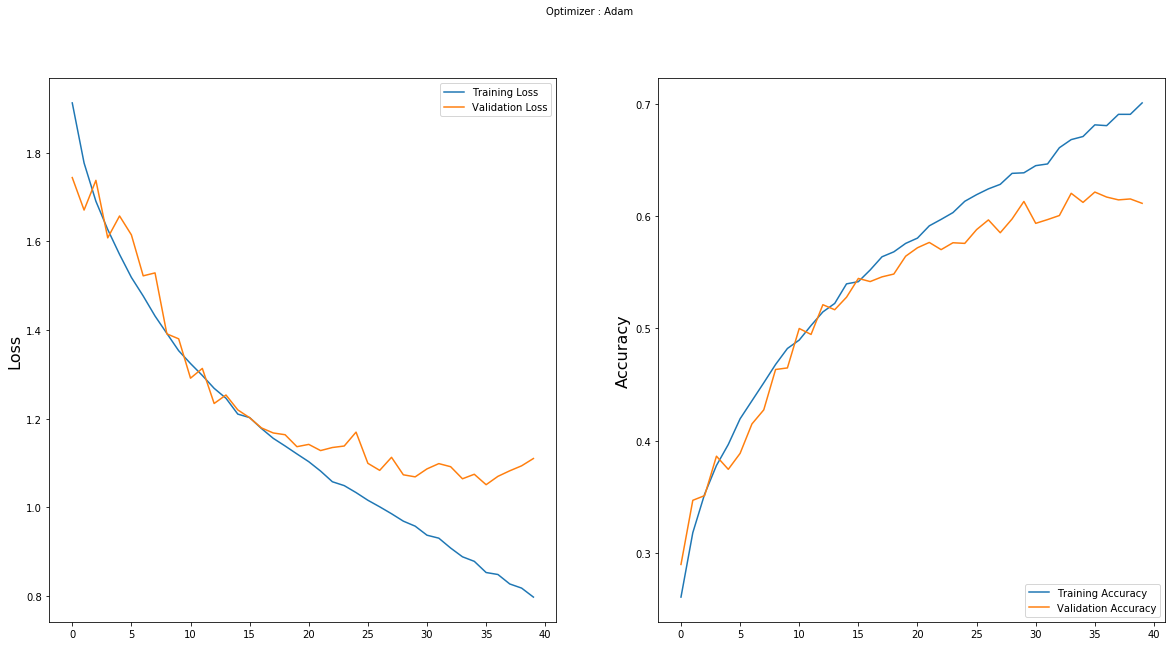

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [0]:
predictions = model.predict_generator(generator=valid_gen)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = valid_gen.classes
class_names = valid_gen.class_indices.keys()


In [0]:
from sklearn.metrics import confusion_matrix
import itertools


<Figure size 432x288 with 0 Axes>

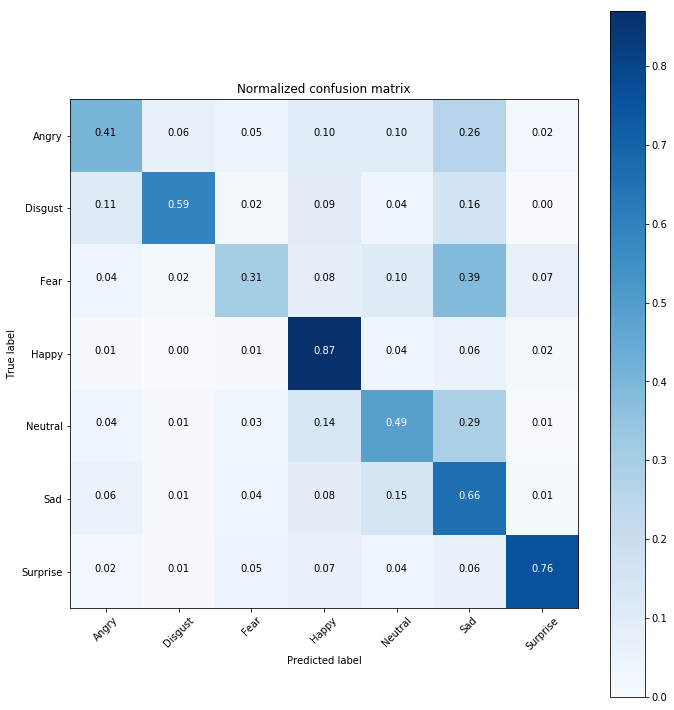

In [0]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [0]:
# model = load_model("drive/My Drive/Deep Learning/model_new_weights.h5")

ValueError: ignored

In [0]:
from tensorflow.keras.models import model_from_json
import numpy as np


In [0]:
# model = model_from_json("model.json")

JSONDecodeError: ignored

In [0]:
# class FacialExpressionModel(object):

#     EMOTIONS_LIST = ["Angry", "Disgust",
#                      "Fear", "Happy",
#                      "Neutral", "Sad",
#                      "Surprise"]

#     def __init__(self, model_json_file, model_weights_file):
#         # load model from JSON file
#         with open(model_json_file, "r") as json_file:
#             loaded_model_json = json_file.read()
#             self.loaded_model = model_from_json(loaded_model_json)

#         # load weights into the new model
#         self.loaded_model.load_weights(model_weights_file)
#         self.loaded_model._make_predict_function()

#     def predict_emotion(self, img):
#         self.preds = self.loaded_model.predict(img)
#         return FacialExpressionModel.EMOTIONS_LIST[np.argmax(self.preds)]


In [0]:
# model.save_weights("drive/My Drive/Deep Learning/model_new_weights.h5")

In [0]:
import cv2
# from model import FacialExpressionModel
import numpy as np

facec = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
model = FacialExpressionModel("model.json", "drive/My Drive/Deep Learning/model_new_weights.h5")
font = cv2.FONT_HERSHEY_SIMPLEX

class VideoCamera(object):
    def __init__(self):
        self.video = cv2.VideoCapture(0)

    def __del__(self):
        self.video.release()

    # returns camera frames along with bounding boxes and predictions
    def get_frame(self):
        _, fr = self.video.read()
        gray_fr = cv2.cvtColor(fr, cv2.COLOR_BGR2GRAY)
        faces = facec.detectMultiScale(gray_fr, 1.3, 5)

        for (x, y, w, h) in faces:
            fc = gray_fr[y:y+h, x:x+w]

            roi = cv2.resize(fc, (48, 48))
            pred = model.predict_emotion(roi[np.newaxis, :, :, np.newaxis])

            cv2.putText(fr, pred, (x, y), font, 1, (255, 255, 0), 2)
            cv2.rectangle(fr,(x,y),(x+w,y+h),(255,0,0),2)

        _, jpeg = cv2.imencode('.jpg', fr)
        return jpeg.tobytes()

In [0]:
# import flask

In [0]:
# from flask import Flask, render_template, Response
# from camera import VideoCamera

In [0]:
# app = Flask(__name__)

In [0]:
# %tb
# @app.route('/')
# def index():
#     return render_template('index.html')

# def gen(camera):
#     while True:
#         frame = VideoCamera.get_frame()
#         yield (b'--frame\r\n'
#                b'Content-Type: image/jpeg\r\n\r\n' + frame + b'\r\n\r\n')

# @app.route('/video_feed')
# def video_feed():
#     return Response(gen(VideoCamera()),
#                     mimetype='multipart/x-mixed-replace; boundary=frame')

# if __name__ == '__main__':
#     app.run(host='https://localhost:5000/', debug=True)

gaierror: ignored

AssertionError: ignored

In [0]:
# app = Flask(__name__)

In [0]:
model.save("model_new.h5")

In [0]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("drive/My Drive/Deep Learning/facial_expression_recog_model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("drive/My Drive/Deep Learning/facial_expression_recog_model_q.tflite", "wb").write(tflite_model)

4482480

In [0]:
import os
basic_model_size = os.path.getsize("drive/My Drive/Deep Learning/facial_expression_recog_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("drive/My Drive/Deep Learning/facial_expression_recog_model_q.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 17887044 bytes
Quantized model is 4482480 bytes
Difference is 13404564 bytes


In [0]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!cd "drive/My Drive/Deep Learning"
!cd "drive/My Drive/Deep Learning" && xxd -i facial_expression_recog_model_q.tflite > facial_expression_recog_model_q.cc
# Print the source file

cat: sine_model_quantized.cc: No such file or directory


In [0]:

!cd "drive/My Drive/Deep Learning" && cat facial_expression_recog_model_q.cc

unsigned char facial_expression_recog_model_q_tflite[] = {
  0x18, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x0e, 0x00,
  0x18, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x0e, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00, 0x28, 0x65, 0x44, 0x00,
  0x90, 0x57, 0x44, 0x00, 0x78, 0x57, 0x44, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x68, 0x57, 0x44, 0x00, 0x58, 0x53, 0x44, 0x00,
  0x48, 0x45, 0x44, 0x00, 0x38, 0x3d, 0x44, 0x00, 0x28, 0x3d, 0x42, 0x00,
  0x18, 0x3d, 0x30, 0x00, 0x08, 0x35, 0x30, 0x00, 0xdc, 0x34, 0x30, 0x00,
  0xcc, 0x34, 0x0c, 0x00, 0xbc, 0x2c, 0x0c, 0x00, 0xac, 0x2a, 0x0c, 0x00,
  0x9c, 0x0a, 0x09, 0x00, 0x8c, 0x01, 0x09, 0x00, 0x84, 0x01, 0x09, 0x00,
  0x7c, 0x01, 0x09, 0x00, 0x74, 0x01, 0x09, 0x00, 0x6c, 0x01, 0x09, 0x00,
  0x64, 0x01, 0x09, 0x00, 0x5c, 0x01, 0x09, 0x00, 0x54, 0x01, 0x09, 0x00,
  0x44, 0x00, 0x09, 0x00, 0x3c, 0x00, 0x09, 0x00, 0x34, 0x00, 0x09, 0x00,
  0x2c, 0x00, 0x09, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



, 0x2b, 0xfe, 0xd2, 0x46, 0x14, 0xe2, 0x1f,
  0x38, 0xd0, 0xe0, 0xda, 0x23, 0x2e, 0xfa, 0xc8, 0x3d, 0x34, 0xe5, 0x0d,
  0xeb, 0x27, 0xd8, 0xfc, 0xd2, 0x28, 0x22, 0x4a, 0x0d, 0xf4, 0x02, 0xc4,
  0x02, 0x3f, 0xdd, 0x2f, 0x3b, 0xde, 0xd3, 0xf1, 0xf1, 0x23, 0xb7, 0xeb,
  0xed, 0xea, 0x08, 0xee, 0x13, 0x31, 0xdb, 0x30, 0x0a, 0x0e, 0x2e, 0xfa,
  0x50, 0xb4, 0xe4, 0x39, 0xdc, 0xdd, 0x3b, 0xf1, 0x04, 0xdb, 0x24, 0x13,
  0x0d, 0xf7, 0xc9, 0xcd, 0x43, 0x4b, 0xf1, 0x26, 0xc6, 0xf1, 0x15, 0xea,
  0xde, 0x06, 0xbf, 0x3d, 0xdf, 0xbe, 0xcd, 0xff, 0xec, 0x3a, 0x13, 0xc3,
  0xbf, 0xea, 0xef, 0x25, 0xe6, 0x07, 0xe9, 0x19, 0x35, 0x20, 0x03, 0xcb,
  0x04, 0x1d, 0xea, 0xd9, 0xd0, 0xf6, 0xd0, 0xea, 0x3a, 0x02, 0x49, 0x16,
  0x0b, 0xdf, 0xdf, 0xeb, 0xef, 0x0c, 0xb7, 0xcc, 0xb1, 0x24, 0x09, 0xbe,
  0x41, 0x16, 0xf2, 0xf1, 0xd6, 0xe3, 0xe4, 0x39, 0xd0, 0x32, 0x1e, 0x39,
  0x03, 0x53, 0x44, 0xb8, 0x42, 0xf2, 0xba, 0xd2, 0x39, 0x52, 0x16, 0x0a,
  0xca, 0xce, 0x17, 0x20, 0x1b, 0xbf, 0x43, 0xeb, 0xe6, 0xd0, 0xe7, 